In [1]:
# !/usr/bin/env python3
# -*- coding: utf-8 -*-

__author__ = 'laolao'
__version__ = '20230526'
__email__ = 'xxx@xxx.com'

from setuptools.package_index import user_agent
import re
import sys
import socket

import fuzzer_plus
from dependent_function import REQUEST_TIMEOUT_HTTP, _debug, UrlOpener, UrlParser, my_reshape

socket.setdefaulttimeout(12.0)
import numpy as np
import pandas as pd
import threading
import os
import queue
import urllib.request
import urllib.parse

try:
    import tlsh

    MODULE_TLSH = True
except ImportError as e:
    _debug(e)
    MODULE_TLSH = False

try:
    import ssdeep

    MODULE_SSDEEP = True
except ImportError as e:
    _debug(e)
    try:
        import ppdeep as ssdeep

        MODULE_SSDEEP = True
    except ImportError as e:
        _debug(e)
        MODULE_SSDEEP = False

try:
    import idna
except ImportError as e:
    _debug(e)


    class idna:
        @staticmethod
        def decode(domain):
            return domain.encode().decode('idna')

        @staticmethod
        def encode(domain):
            return domain.encode('idna')

VALID_FQDN_REGEX = re.compile(r'(?=^.{4,253}$)(^((?!-)[a-z0-9-]{1,63}(?<!-)\.)+[a-z0-9-]{2,63}$)',
                              re.IGNORECASE)  # 有效的FQDN正则表达式
USER_AGENT_STRING = 'Mozilla/5.0 ({} {}-bit) dnstwist/{}'.format(sys.platform, sys.maxsize.bit_length() + 1,
                                                                 __version__)
THREAD_COUNT_DEFAULT = min(32, os.cpu_count() + 4)


def search_dns(domains, _type=1, thread_num=4):
    ''':cvar
    _type：控制查询级别，默认查询A记录
        1：A
        2: NS
        3: MX
        4+: AAAA
    A记录，将主机名转换为IP地址；[默认]
    MX记录，邮件交换记录，定义邮件服务器的域名；
    NS记录，标记区域的域名服务器及授权子域；
    AAAA记录，ipv6
    '''
    print('Fuzzer后生成的域名：\n')
    print(pd.DataFrame(domains))
    domains = list(domains)
    from dns.resolver import Resolver
    import dns.rdatatype
    resolv = Resolver()
    if hasattr(resolv, 'resolve'):
        resolve = resolv.resolve
    else:
        resolve = resolv.query

    def __answer_to_list(_, _type):
        ''':cvar 输入域名，输出对应的dns记录'''
        try:
            if _type == 2:
                _re = resolve(_, rdtype=dns.rdatatype.NS)
            elif _type == 3:
                _re = resolve(_, rdtype=dns.rdatatype.MX)
            elif _type >= 4:
                _re = resolve(_, rdtype=dns.rdatatype.AAAA)
            else:
                _re = resolve(_, rdtype=dns.rdatatype.A)
            _ = []
            for i in _re:
                for j in str(i).split('\n'):
                    _.append(j.split(' ')[-1])
            return _
        except:
            print('>{} 解析结果：Check no record'.format(_))
            return []

    def __job_search_dns(domains, q):
        for _ in domains:
            ip_list = __answer_to_list(_['domain'], _type)
            if len(ip_list):  # 没有记录的直接过滤掉
                _['dns_record'] = ','.join(list(set(ip_list)))
                print('>{} 解析结果：{}'.format(_['domain'], _['dns_record']))
                q.put(_)

    q = queue.Queue()
    threads = []  # 线程列表
    data = my_reshape(domains, thread_num)
    for i in range(thread_num):
        t = threading.Thread(target=__job_search_dns, args=(data[i], q))
        t.start()
        threads.append(t)
    for thread in threads:
        thread.join()
    new_domains = []
    for _ in range(q.qsize()):
        new_domains.append(q.get())
    print("\nDNS查询过滤域名个数：{}->{}".format(len(domains), len(new_domains)))
    print(pd.DataFrame(new_domains))
    return new_domains


def __job_LSH_alg(domains, lsh_init, REQUEST_TIMEOUT_HTTP, option_lsh, q):
    for _ in domains:
        try:
            r = UrlOpener(UrlParser(_['domain']).full_uri(),
                          timeout=REQUEST_TIMEOUT_HTTP,
                          headers={'user-agent': user_agent},
                          verify=False)
        except Exception as e:
            print(">{}查询出错：{}".format(_['domain'], e))
            _['LSH_score'] = -1
            q.put(_)
        else:
            _['LSH_score'] = -1  # 默认值 -1
            if option_lsh == 'ssdeep':
                lsh_curr = ssdeep.hash(r.normalized_content)
                if lsh_curr not in (None, '3::'):
                    _['LSH_score'] = ssdeep.compare(lsh_init, lsh_curr)
            elif option_lsh == 'tlsh':
                lsh_curr = tlsh.hash(r.normalized_content)
                if lsh_curr not in (None, '', 'TNULL'):
                    _['LSH_score'] = int(100 - (min(tlsh.diff(lsh_init, lsh_curr), 300) / 3))
            print('>{}的LSH得分：{}'.format(_['domain'], _['LSH_score']))
            q.put(_)


def LSH_alg(url_raw, domains, REQUEST_TIMEOUT_HTTP, user_agent, option_lsh='ssdeep', thread_num=4):
    print('\n将要进行LSH检测的域名：\n')
    print(pd.DataFrame(domains))
    r = UrlOpener(UrlParser(url_raw).full_uri(),
                  timeout=REQUEST_TIMEOUT_HTTP,
                  headers={'user-agent': user_agent},
                  verify=False)
    if option_lsh == 'ssdeep':
        lsh_init = ssdeep.hash(r.normalized_content)
    else:
        lsh_init = tlsh.hash(r.normalized_content)

    q = queue.Queue()
    threads = []  # 线程列表
    data = my_reshape(domains, thread_num)

    for i in range(thread_num):
        t = threading.Thread(target=__job_LSH_alg, args=(data[i], lsh_init, REQUEST_TIMEOUT_HTTP, option_lsh, q))
        t.start()
        threads.append(t)
    for thread in threads:
        thread.join()
    new_domains = []
    for _ in range(q.qsize()):
        new_domains.append(q.get())
    return new_domains

In [2]:
args = {
    'all': False,
    'format': 'cli',  # csv/json/cli
    'domain': 'https://blog.csdn.net/',
    'option_lsh': 'ssdeep',  # 使用LSH算法评估网页相似度: ssdeep, tlsh(默认:ssdeep)
    'phash': False,
    'screenshots': False,  # argument --screenshots requires --phash
    'threads': 20,
    'dns_type': 1,
    'fuzzer_num': np.inf,  # 0-inf，inf代表输出所有的生成结果
    'threshold_value': 0.15,
    'tld_all': True,
    'fuzzers': [
        'addition', 'bitsquatting',
        'cyrillic', 'homoglyph',
        'hyphenation',
        'insertion', 'omission', 'repetition', 'replacement',
        'subdomain', 'transposition', 'vowel-swap', 'dictionary'
    ],
    'useragent': USER_AGENT_STRING,
    'request_timeout_http': REQUEST_TIMEOUT_HTTP
}
url = UrlParser(args['domain'])
fuzz = fuzzer_plus.Fuzzer(url.domain, tld_all=args['tld_all'], threshold_value=args['threshold_value'], top=args['fuzzer_num'])
fuzz.generate(args['fuzzers'])
domains = fuzz.domains

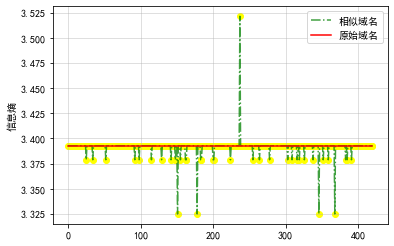

In [3]:
fuzz._make_fig(url.domain)

In [4]:
fuzz._save_domains("生成的混淆域名")

文件：D:\Desktop\上班\dnstwist-20230509\Similar_domain_name_detection\生成的混淆域名.csv保存成功


In [5]:
domains = search_dns(domains, _type=args['dns_type'], thread_num=args['threads'])

Fuzzer后生成的域名：

        fuzzer         domain  score
0    homoglyph  blog.ćsḋn.net    0.0
1     addition  blog.scdn.net    0.0
2    homoglyph  blog.cșḏn.net    0.0
3    homoglyph  blog.cṡɗn.net    0.0
4     addition  blog.qsdn.net    0.0
..         ...            ...    ...
416  homoglyph  blog.cṡḓn.net    0.0
417  homoglyph  blog.čꜱdn.net    0.0
418  homoglyph  blog.čsďn.net    0.0
419   addition  blog.nscd.net    0.0
420   addition  blog.csdl.net    0.0

[421 rows x 3 columns]
>blog.dsnc.net 解析结果：121.254.178.252
>blog.ĉsḓn.net 解析结果：Check no record>blog.ćsḋn.net 解析结果：Check no record

>blog.csde.net 解析结果：76.223.54.146,13.248.169.48
>blog.esdñ.net 解析结果：Check no record
>blog.csḑn.net 解析结果：Check no record
>blog.csḇn.net 解析结果：Check no record
>blog.cʂđn.net 解析结果：Check no record
>blog.cshn.net 解析结果：Check no record
>blog.0sdn.net 解析结果：Check no record
>blog.ćsđn.net 解析结果：Check no record
>blog.ᴄṣdn.net 解析结果：Check no record
>blog.ᴄsḍn.net 解析结果：Check no record
>blog.cṣḓn.net 解析结果：Check no record
>

>blog.cṡđn.net 解析结果：Check no record
>blog.ĉsḑn.net 解析结果：Check no record
>blog.çšdn.net 解析结果：Check no record
>blog.cšɖn.net 解析结果：Check no record
>blog.ćsḓn.net 解析结果：Check no record
>blog.ĉʂdn.net 解析结果：Check no record
>blog.cydn.net 解析结果：Check no record
>blog.cșḋn.net 解析结果：Check no record
>blog.cșɗn.net 解析结果：Check no record
>blog.csndn.net 解析结果：Check no record
>blog.čsḋn.net 解析结果：Check no record
>blog.cŝḍn.net 解析结果：Check no record
>blog.zsdn.net 解析结果：Check no record
>blog.ĉsdn.net 解析结果：Check no record
>blog.ċsɗn.net 解析结果：Check no record
>blog.esdm.net 解析结果：183.111.183.126
>blog.csclń.net 解析结果：Check no record
>blog.ƈsďn.net 解析结果：Check no record
>blog.cŝḓn.net 解析结果：Check no record
>blog.esdń.net 解析结果：Check no record
>blog.csɓn.net 解析结果：Check no record
>blog.cxdn.net 解析结果：Check no record
>blog.ėsdn.net 解析结果：Check no record
>blog.ᴄsḓn.net 解析结果：Check no record
>blog.çsdn.net 解析结果：Check no record
>blog.ᴄsđn.net 解析结果：Check no record
>blog.ĉșdn.net 解析结果：Check no record
>blog.ᴄşdn.net 解析结果：Check 

In [6]:
pd.DataFrame(domains)

,fuzzer,domain,score,dns_record
0,addition,blog.dsnc.net,0.000000e+00,121.254.178.252
1,addition,blog.csde.net,0.000000e+00,"76.223.54.146,13.248.169.48"
2,addition,blog.scdn.net,0.000000e+00,47.241.101.94
3,addition,blog.csdt.net,4.440892e-16,49.234.64.171
4,addition,blog.chdn.net,0.000000e+00,50.3.202.91
5,addition,blog.nsdc.net,0.000000e+00,3.64.163.50
6,addition,blog.ccsdn.net,1.396392e-02,103.231.13.42
7,addition,blog.hsdn.net,0.000000e+00,"104.21.45.141,172.67.215.48"
8,addition,blog.sdcn.net,0.000000e+00,3.64.163.50
9,addition,blog.ndsc.net,0.000000e+00,"76.223.54.146,13.248.169.48"


In [7]:
domains = LSH_alg(args['domain'], domains, args['request_timeout_http'], args['useragent'], args['option_lsh'])


将要进行LSH检测的域名：

       fuzzer          domain         score  \
0    addition   blog.dsnc.net  0.000000e+00   
1    addition   blog.csde.net  0.000000e+00   
2    addition   blog.scdn.net  0.000000e+00   
3    addition   blog.csdt.net  4.440892e-16   
4    addition   blog.chdn.net  0.000000e+00   
5    addition   blog.nsdc.net  0.000000e+00   
6    addition  blog.ccsdn.net  1.396392e-02   
7    addition   blog.hsdn.net  0.000000e+00   
8    addition   blog.sdcn.net  0.000000e+00   
9    addition   blog.ndsc.net  0.000000e+00   
10   addition   blog.cfdn.net  0.000000e+00   
11   addition   blog.csin.net  0.000000e+00   
12   addition   blog.dscn.net  0.000000e+00   
13   addition   blog.sncd.net  0.000000e+00   
14   addition   blog.csmn.net  0.000000e+00   
15  homoglyph   blog.csbm.net  0.000000e+00   
16   addition   blog.sdnc.net  0.000000e+00   
17   addition   blog.ndcs.net  0.000000e+00   
18   addition   blog.dcns.net  0.000000e+00   
19   addition   blog.cqdn.net  0.000000e+00 

In [8]:
pd.DataFrame(domains)

,fuzzer,domain,score,dns_record,LSH_score
0,addition,blog.dsnc.net,0.000000e+00,121.254.178.252,-1
1,addition,blog.dcns.net,0.000000e+00,"76.223.54.146,13.248.169.48",-1
2,addition,blog.ndsc.net,0.000000e+00,"76.223.54.146,13.248.169.48",-1
3,addition,blog.csjn.net,0.000000e+00,"65.21.240.245,195.201.124.255,159.69.83.207",-1
4,addition,blog.csde.net,0.000000e+00,"76.223.54.146,13.248.169.48",-1
5,addition,blog.cswn.net,0.000000e+00,103.211.68.108,-1
6,addition,blog.scdn.net,0.000000e+00,47.241.101.94,0
7,addition,blog.cfdn.net,0.000000e+00,"76.223.54.146,13.248.169.48",-1
8,addition,blog.csdt.net,4.440892e-16,49.234.64.171,0
9,addition,blog.csdb.net,0.000000e+00,104.165.254.152,0


In [30]:
try:
	import idna
except ImportError as e:
	_debug(e)
	class idna:
		@staticmethod
		def decode(domain):
			return domain.encode().decode('idna')
		@staticmethod
		def encode(domain):
			return domain.encode('idna')

In [31]:
#!/usr/bin/python3
ed=idna.encode('www.cnbl.com').decode()
ed

'www.cnbl.com'

In [32]:
search_dns([{'domain':ed}], _type=1, thread_num=1)

Fuzzer后生成的域名：

         domain
0  www.cnbl.com
>www.cnbl.com 解析结果：206.119.87.32

DNS查询过滤域名个数：1->1
         domain     dns_record
0  www.cnbl.com  206.119.87.32


[{'domain': 'www.cnbl.com', 'dns_record': '206.119.87.32'}]